In [27]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian
from jax.lax import scan
from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np

from jax.experimental import stax, optimizers
from jax.flatten_util import ravel_pytree

import numpy as onp
from constrained_opt import AugmentedLagrangian
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [39]:
x0 = np.array([0.54,0.3, 0.1])
n,m,T = 3, 2, 200
x = np.ones((T, n)) * x0
# x = np.array(onp.random.uniform(0,1,size=(T, n)))
u = np.zeros((T, m))
z = np.concatenate([x, u], axis=1)
z = u

In [40]:
def f(x, u):
    B = np.array([
        [np.cos(x[2]), 0.,],
        [np.sin(x[2]), 0.],
        [0., 1.]
    ])
    return x + 0.1*B@np.tanh(u)

@jit
def sim(x0, u):
    return scan(lambda x,u: (f(x, u), x), x0, u)

In [41]:
def p(x): # uniform distribution
    return np.exp(-60.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-60.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-60.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2)) \
                + np.exp(-60.5 * np.sum((x[:2] - np.array([0.75, 0.2]))**2))


def get_hk(k): # normalizing factor for basis function
    _hk = (2. * k + onp.sin(2 * k))/(4. * k)
    _hk = _hk.at[onp.isnan(_hk)].set(1.)
    return onp.sqrt(onp.prod(_hk))

def fk(x, k): # basis function
    return np.prod(np.cos(x*k))

k1, k2 = np.meshgrid(*[np.arange(0, 15, step=1)]*2)
k = np.stack([k1.ravel(), k2.ravel()]).T
k = np.pi*k

lamk = (1.+np.linalg.norm(k/np.pi,axis=1)**2)**(-4./2.)
# lamk = np.exp(-0.8 * np.linalg.norm(k, axis=1))
# lamk = np.ones((len(k), 1))
hk = []
for ki in k:
    hk.append(get_hk(ki))
hk = np.array(hk)

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)
def get_ck(tr, k):
    ck = np.mean(vmap(partial(fk_vmap, tr))(k), axis=1)
    ck = ck / hk
    return ck

X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(_s, k), vmap(p)(_s))
phik = phik/phik[0]
phik = phik/hk

@vmap
def emap(x):
    return x[:2]

@vmap
def barrier_cost(e):
    return np.maximum(0, e-1) + np.maximum(0, -e)

@jit
def fourier_ergodic_loss(z):
    u = z
    _, x = sim(x0, u)
    # x, u = z[:, :n], z[:, n:]
    e = emap(x)
    ck = get_ck(e, k)
    return np.sum(lamk*np.square(phik - ck)) \
            + 0 * np.mean(u**2) + np.mean(barrier_cost(e))

fourier_ergodic_loss(z)

DeviceArray(0.41471586, dtype=float32)

In [42]:


def eq_constr(z):
    return np.zeros(1)
    # x, u = z[:, :n], z[:, n:]
    # return np.vstack([x[0]-x0, x[1:,:] - vmap(f)(x[:-1,:], u[:-1,:])])

def ineq_constr(z):
    return np.zeros(1)
    # x, u = z[:, :n], z[:, n:]
    # e = emap(x)
    # ine1 = np.maximum(0, e-1) + np.maximum(0, -e)
    # return ine1
    # ine2 = np.abs(u) - 1.
    # return np.concatenate([ine1.flatten(), ine2.flatten()])


In [47]:
problem = AugmentedLagrangian(z, fourier_ergodic_loss, eq_constr, ineq_constr, step_size=1e-1, c=0.01)

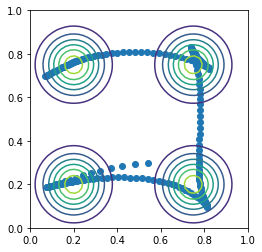

In [49]:
for _ in range(100):
    problem.solve(max_iter=100)

    clear_output(wait=True)
    plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))
    tr = sim(x0, problem.solution['x'])[1]
    # plt.scatter(problem.solution['x'][:,0], problem.solution['x'][:,1])
    plt.scatter(tr[:,0], tr[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axis('square')
    plt.show()